In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
input_file = "lending-club-data.csv"
loans = pd.read_csv(input_file, header = 0)

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loans.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


In [4]:
# bad_loans =  0 => safe
# bad_loans =  1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)

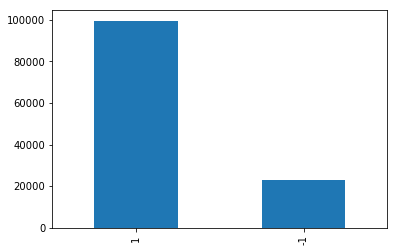

In [5]:
loans.safe_loans.value_counts().plot(kind='bar')

In [7]:
safe_loans_raw = loans[loans[ 'safe_loans'] == +1]
risky_loans_raw = loans[loans[ 'safe_loans'] == -1]
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(frac = percentage)
loans_data = risky_loans_raw.append(safe_loans)

In [8]:
safe = loans_data[loans_data[ 'safe_loans'] == +1]
risky = loans_data[loans_data[ 'safe_loans'] == -1]

In [9]:
# Features to used in this analysis 

features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans_data = loans_data[features + [target]]

In [10]:
loans_data.head(5)

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0,-1
6,F,F2,0,5,OWN,5.55,small_business,60 months,1,1,32.6,0.0,-1
7,B,B5,1,1,RENT,18.08,other,60 months,1,1,36.5,0.0,-1
10,C,C1,1,1,RENT,10.08,debt_consolidation,36 months,1,1,91.7,0.0,-1
12,B,B2,0,4,RENT,7.06,other,36 months,1,1,55.5,0.0,-1


## Decision Tree

In [11]:
# Training & Validation data

from sklearn.cross_validation import train_test_split
train_data, validation_data = train_test_split(loans_data, test_size = 0.1)

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
train_data.shape

(41670, 13)

In [13]:
validation_data.shape

(4630, 13)

In [14]:
# Convert data into numpy

def get_numpy_data(data_frame, features, label):
    features_array = np.array(data_frame[features])
    label_array = np.array(data_frame[label])
    return(features_array, label_array)


train_feature_matrix, train_target_matrix = get_numpy_data(train_data, features, target) 
validation_feature_matrix, validation_target_matrix = get_numpy_data(validation_data, features, target) 

In [15]:
# Convert into incremental value
#http://stackoverflow.com/questions/30384995/randomforestclassfier-fit-valueerror-could-not-convert-string-to-float

from sklearn import preprocessing
#le = preprocessing.LabelEncoder()

l0e = preprocessing.LabelEncoder()
l0 = l0e.fit(train_feature_matrix[:,0])
train_feature_matrix[:,0]= l0.transform(train_feature_matrix[:,0])
validation_feature_matrix[:,0]= l0.transform(validation_feature_matrix[:,0])

l1e = preprocessing.LabelEncoder()
l1 = l1e.fit(train_feature_matrix[:,1])
train_feature_matrix[:,1]= l1.transform(train_feature_matrix[:,1])
validation_feature_matrix[:,1]= l1.transform(validation_feature_matrix[:,1])

l4e = preprocessing.LabelEncoder()
l4 = l4e.fit(train_feature_matrix[:,4])
train_feature_matrix[:,4]= l4.transform(train_feature_matrix[:,4])
validation_feature_matrix[:,4]= l4.transform(validation_feature_matrix[:,4])

l6e = preprocessing.LabelEncoder()
l6 = l6e.fit(train_feature_matrix[:,6])
train_feature_matrix[:,6]= l6.transform(train_feature_matrix[:,6])
validation_feature_matrix[:,6]= l6.transform(validation_feature_matrix[:,6])

l7e = preprocessing.LabelEncoder()
l7 = l7e.fit(train_feature_matrix[:,7])
train_feature_matrix[:,7]= l7.transform(train_feature_matrix[:,7])
validation_feature_matrix[:,7]= l7.transform(validation_feature_matrix[:,7])


In [16]:
train_target_matrix[1:10]

array([ 1,  1,  1,  1, -1, -1,  1,  1,  1], dtype=int64)

In [24]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dt1 = tree.DecisionTreeClassifier(max_depth=6)
#clf = dt.fit(train_feature_matrix, train_target_matrix)

In [25]:
from sklearn.cross_validation import cross_val_predict, KFold
kf = KFold(train_feature_matrix.shape[0], random_state=42)
predictions = cross_val_predict(dt1, train_feature_matrix, train_target_matrix, cv=kf)
predictions = pd.Series(predictions)

In [28]:
false_positive_filter = (predictions == 1) & (loans_data['safe_loans'] == -1)
false_positive = len(predictions[false_positive_filter])

true_positive_filter = (predictions == 1) & (loans_data['safe_loans'] == 1)
true_positive = len(predictions[true_positive_filter])

false_negative_filter = (predictions == -1) & (loans_data['safe_loans'] == 1)
false_negative = len(predictions[false_negative_filter])

true_negative_filter = (predictions == -1) & (loans_data['safe_loans'] == -1)
true_negative = len(predictions[true_negative_filter])

true_positive_rate = float(true_positive)/float((true_positive + false_negative))
false_positive_rate = float(false_positive)/float((false_positive + true_negative))

print (float(true_positive_rate) )
print (float(false_positive_rate))

0.50390625
0.5020224719101124


In [29]:
precision = float(true_positive)/float(true_positive + false_positive)
precision

0.5519454472523064

In [ ]:
clf = dt1.fit(train_feature_matrix, train_target_matrix)

In [19]:
predicted = clf.predict(train_feature_matrix)

num_mistakes = (predicted != train_target_matrix).sum() 
num_correct = len(train_target_matrix) - num_mistakes
accuracy = num_correct/float(len(train_target_matrix)) 
print ('Accuracy on training data = %.2f' % accuracy)

Accuracy on training data = 0.64


In [23]:
predicted = clf.predict(validation_feature_matrix)

num_mistakes = (predicted != validation_target_matrix).sum() 
num_correct = len(validation_target_matrix) - num_mistakes
accuracy = num_correct/float(len(validation_target_matrix)) 
print ('Accuracy on validation data = %.2f' % accuracy)

Accuracy on validation data = 0.64


## Ensamble Boosting

In [30]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [31]:
loans.shape

(122607, 69)

In [32]:
loans_data2 = loans[[target] + features].dropna() 

In [33]:
safe_loans_raw = loans_data2[loans_data2[target] == 1]
risky_loans_raw = loans_data2[loans_data2[target] == -1]

percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(frac = percentage)

# Append the risky_loans with the downsampled version of safe_loans
loans_data2 = risky_loans_raw.append(safe_loans)

In [34]:
safe_loans_raw = loans_data2[loans_data2[target] == 1]
risky_loans_raw = loans_data2[loans_data2[target] == -1]

In [35]:
len(risky_loans_raw)

23147

In [36]:
len(safe_loans_raw)

23147

In [37]:
from sklearn.cross_validation import train_test_split
train_data2, validation_data2 = train_test_split(loans_data2, test_size = 0.2)

In [38]:
def get_numpy_data(data_frame, features, label):
    features_array = np.array(data_frame[features])
    label_array = np.array(data_frame[label])
    return(features_array, label_array)


train_feature_matrix, train_target_matrix = get_numpy_data(train_data2, features, target) 
validation_feature_matrix, validation_target_matrix = get_numpy_data(validation_data2, features, target) 

In [39]:
train_feature_matrix[1:2]

array([['D', 0.4, 1, 1, 'RENT', 12.7, 'debt_consolidation', 8.73584, 0.0,
        1.0, 3.0, 1, 1, 5.0, 0.0, 1.0, 94.7, 0.0, 18.49, 2619.81, 75000.0,
        15000, 14775, 545.99]], dtype=object)

In [40]:
from sklearn import preprocessing
#le = preprocessing.LabelEncoder()

l0e = preprocessing.LabelEncoder()
l0 = l0e.fit(train_feature_matrix[:,0])
train_feature_matrix[:,0]= l0.transform(train_feature_matrix[:,0])
validation_feature_matrix[:,0]= l0.transform(validation_feature_matrix[:,0])

l1e = preprocessing.LabelEncoder()
l1 = l1e.fit(train_feature_matrix[:,4])
train_feature_matrix[:,4]= l1.transform(train_feature_matrix[:,4])
validation_feature_matrix[:,4]= l1.transform(validation_feature_matrix[:,4])

l4e = preprocessing.LabelEncoder()
l4 = l4e.fit(train_feature_matrix[:,6])
train_feature_matrix[:,6]= l4.transform(train_feature_matrix[:,6])
validation_feature_matrix[:,6]= l4.transform(validation_feature_matrix[:,6])

In [42]:
train_feature_matrix[1:2]

array([[3, 0.4, 1, 1, 3, 12.7, 2, 8.73584, 0.0, 1.0, 3.0, 1, 1, 5.0, 0.0,
        1.0, 94.7, 0.0, 18.49, 2619.81, 75000.0, 15000, 14775, 545.99]], dtype=object)

In [41]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

dt = GradientBoostingClassifier(n_estimators=200, max_depth=3)
# clf4 = dt.fit(train_feature_matrix, train_target_matrix)

In [43]:
kf = KFold(train_feature_matrix.shape[0], random_state=42)
predictions = cross_val_predict(dt, train_feature_matrix, train_target_matrix, cv=kf)
predictions = pd.Series(predictions)

In [44]:
false_positive_filter = (predictions == 1) & (loans_data['safe_loans'] == -1)
false_positive = len(predictions[false_positive_filter])

true_positive_filter = (predictions == 1) & (loans_data['safe_loans'] == 1)
true_positive = len(predictions[true_positive_filter])

false_negative_filter = (predictions == -1) & (loans_data['safe_loans'] == 1)
false_negative = len(predictions[false_negative_filter])

true_negative_filter = (predictions == -1) & (loans_data['safe_loans'] == -1)
true_negative = len(predictions[true_negative_filter])

true_positive_rate = float(true_positive)/float((true_positive + false_negative))
false_positive_rate = float(false_positive)/float((false_positive + true_negative))

print (float(true_positive_rate) )
print (float(false_positive_rate))

0.5037430243636859
0.5043798177995795


In [45]:
precision = float(true_positive)/float(true_positive + false_positive)
precision

0.5624620060790274

In [71]:
clf4 = dt.fit(train_feature_matrix, train_target_matrix)

In [72]:
predicted = clf4.predict(validation_feature_matrix)

num_mistakes = (predicted != validation_target_matrix).sum() 
num_correct = len(validation_target_matrix) - num_mistakes
accuracy = num_correct/float(len(validation_target_matrix)) 
print ('Accuracy on validation data = %.2f' % accuracy)

Accuracy on validation data = 0.69


In [52]:
ntree = [10,50,100,200,300,400,500]
training_err = []
validation_err = []

for i in ntree:
    dt = GradientBoostingClassifier(n_estimators=i, max_depth=6)
    clf = dt.fit(train_feature_matrix, train_target_matrix)
    
    train_predict = clf.predict(train_feature_matrix)
    t_err = 1 - calculate_accuracy(train_predict,train_target_matrix)
    training_err.append(t_err)
    
    validation_predict = clf.predict(validation_feature_matrix)
    v_err = 1 - calculate_accuracy(validation_predict, validation_target_matrix) 
    validation_err.append(v_err)

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

## Random Forest

In [60]:
import sklearn
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500,n_jobs=4)

In [61]:
kf = KFold(train_feature_matrix.shape[0], random_state=42)
predictions = cross_val_predict(rf, train_feature_matrix, train_target_matrix, cv=kf)
predictions = pd.Series(predictions)

In [62]:
false_positive_filter = (predictions == 1) & (loans_data['safe_loans'] == -1)
false_positive = len(predictions[false_positive_filter])

true_positive_filter = (predictions == 1) & (loans_data['safe_loans'] == 1)
true_positive = len(predictions[true_positive_filter])

false_negative_filter = (predictions == -1) & (loans_data['safe_loans'] == 1)
false_negative = len(predictions[false_negative_filter])

true_negative_filter = (predictions == -1) & (loans_data['safe_loans'] == -1)
true_negative = len(predictions[true_negative_filter])

true_positive_rate = float(true_positive)/float((true_positive + false_negative))
false_positive_rate = float(false_positive)/float((false_positive + true_negative))

print (float(true_positive_rate) )
print (float(false_positive_rate))

0.49285422621478153
0.49649614576033635


In [59]:
precision = float(true_positive)/float(true_positive + false_positive)
precision

0.5590513833992095

In [63]:
clf5 = rf.fit(train_feature_matrix, train_target_matrix)
predicted_rf = clf5.predict(validation_feature_matrix)
calculate_accuracy(predicted_rf,validation_target_matrix)

0.6840911545523275

## Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_predict
cross_val_predict, KFold


lr = LogisticRegression()
kf = KFold(train_feature_matrix.shape[0], random_state=42)
predictions = cross_val_predict(lr, train_feature_matrix, train_target_matrix, cv= kf)
predictions = pd.Series(predictions)

In [68]:
false_positive_filter = (predictions == 1) & (loans_data['safe_loans'] == -1)
false_positive = len(predictions[false_positive_filter])

true_positive_filter = (predictions == 1) & (loans_data['safe_loans'] == 1)
true_positive = len(predictions[true_positive_filter])

false_negative_filter = (predictions == -1) & (loans_data['safe_loans'] == 1)
false_negative = len(predictions[false_negative_filter])

true_negative_filter = (predictions == -1) & (loans_data['safe_loans'] == -1)
true_negative = len(predictions[true_negative_filter])

true_positive_rate = float(true_positive)/float((true_positive + false_negative))
false_positive_rate = float(false_positive)/float((false_positive + true_negative))

print (float(true_positive_rate) )
print (float(false_positive_rate))

0.4660405607731047
0.4730203223545901


In [69]:
precision = float(true_positive)/float(true_positive + false_positive)
precision

0.5591116917047682

In [70]:
clf5 = lr.fit(train_feature_matrix, train_target_matrix)
predicted_rf = clf5.predict(validation_feature_matrix)
calculate_accuracy(predicted_rf,validation_target_matrix)

0.64801814450804618